# San Francisco Crime Classification

**[Mert Gunes]** Xebia provided this notebook's template as part of the hackathon during their "Advanced Data Science with Python" training on 19-20 May 2025. I wrote the code in this noteobok, with assistance from GitHub Copilot, to complete the classification challenge. Note that you will find my name stamped wherever I made observations or comments so as to differentiate them from the template's markdowns.

## Introduction
From 2010 - 2015 the San Francisco police department made records crime reports from across all of San Francisco's neighborhoods. 

Our task is **to predict if the crime was theft or not!**

![](https://digital.ihg.com/is/image/ihg/holiday-inn-san-francisco-6019097353-2x1)

The following information has been recorded in our data: 
* `Dates` - timestamp of the crime incident
* `Category` - category of the crime incident. 
* `Descript` - detailed description of the crime incident (not available in live data)
* `PdDistrict` - name of the Police Department District
* `Resolution` - how the crime incident was resolved (not available in live data)
* `Address` - the approximate street address of the crime incident
* `X` - Longitude
* `Y` - Latitude
* `Theft` - A flag that states if the crime was a theft or larcency. **This is the target variable you are going to predict.**

Our target is **Theft**. Alternatively you can build a model to predict `Category`. This will be a bit harder since there are so many categories of crime.

This dataset and the corresponding challenge was part of a competition hosted by Kaggle and many people have attempted to solve this problem before you. Take a look at what people have tried at the [Kaggle site](https://www.kaggle.com/c/sf-crime/notebooks).

## Import the libraries

Use this next cell to import the libraries you need, pandas is already done for you. If you need more the further down the notebook you get come back and add them to this cell.

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_selector as selector

import joblib

## Steps to follow

We are going to follow the following project steps:

- Import the data
- Exploratory Data Analysis
- In-depth Data Analysis
- Feature Engineering
- Preparing the Data for Sci-kit Learn
- Use a transformer on categorical features
- Build a pipeline
- Using grid search on model parameters
- Analysing model predictive power
- Further improvements
- Conclusion/suggestions for future

## Import the data

First import the data from the `sf_crime_hackathon.csv` in the `/data` folder.

In [2]:
df = pd.read_csv('data/sf_crime_hackathon.csv')

## Data exploration

### Part 1: Exploratory Analysis

Run some of the following to start to learn about your data:

- `df.head()`, `df.tail()`, `df.sample(5)`
- `df.shape`
- `df.describe()`
- `df.info()`
- `df.dtypes`

In [3]:
df.head()

,Dates,Category,Descript,PdDistrict,Resolution,Address,X,Y,Theft
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,0
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,0
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,1
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,1


In [4]:
df.shape

(382848, 9)

In [5]:
df.describe()

,X,Y,Theft
count,382848.000000,382848.000000,382848.000000
mean,-122.422728,37.767482,0.223329
std,0.025428,0.023972,0.416478
min,-122.513642,37.707922,0.000000
25%,-122.433271,37.753535,0.000000
50%,-122.416309,37.775421,0.000000
75%,-122.406605,37.784477,0.000000
max,-122.365241,37.819975,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382848 entries, 0 to 382847
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       382848 non-null  object 
 1   Category    382848 non-null  object 
 2   Descript    382848 non-null  object 
 3   PdDistrict  382848 non-null  object 
 4   Resolution  382848 non-null  object 
 5   Address     382848 non-null  object 
 6   X           382848 non-null  float64
 7   Y           382848 non-null  float64
 8   Theft       382848 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 26.3+ MB


In [7]:
df.dtypes

Dates          object
Category       object
Descript       object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
Theft           int64
dtype: object

Is everything as you'd expect?

You may have noticed that we need to clean our data before we can do any analysis.
Re-read the data in and add parameters to `.read_csv()` and chain methods to:
- parse the type of the `dates` column
- rename the colums to be all lower case (or upper if you prefer)
- rename the column `dates` to be `date`

In [8]:
# Re-read the data by parse the type of the 'Dates' column, rename all columns to lowercase, and rename 'dates' column to 'date'
df = pd.read_csv('data/sf_crime_hackathon.csv', parse_dates=['Dates'])
df.columns = df.columns.str.lower()
df.rename(columns={'dates': 'date'}, inplace=True)

# Check the data types again
display(df.head())
df.dtypes


,date,category,descript,pddistrict,resolution,address,x,y,theft
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,0
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,0
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,1
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,1


date          datetime64[ns]
category              object
descript              object
pddistrict            object
resolution            object
address               object
x                    float64
y                    float64
theft                  int64
dtype: object

### Part 2: In-depth Analysis (with optional visualisations)

Answer the following questions and make 2 up of your own to answer. Here you have the option to visualise your results using `.plot()`. 

1. How many missing values are there in the data?

In [9]:
print(df.isnull().sum().sum())

0


2. How many unique values for address are there?

In [10]:
df['address'].nunique()

19538

3. What are the top 10 largest categories?

In [11]:
df['category'].value_counts().head(10)

category
LARCENY/THEFT     85501
OTHER OFFENSES    53370
NON-CRIMINAL      46766
ASSAULT           33303
VANDALISM         19858
DRUG/NARCOTIC     18108
WARRANTS          17731
VEHICLE THEFT     15793
SUSPICIOUS OCC    15382
BURGLARY          15307
Name: count, dtype: int64

4. Which month has the most amount of data?

In [12]:
print(df['date'].dt.to_period('M').value_counts().index[0])

2013-10


5. Which district has the most amount of crime? Which has the least?

In [13]:
print(f"Most crime in {df['pddistrict'].value_counts().head(1).index[0]}")
print(f"Least crime in {df['pddistrict'].value_counts().tail(1).index[0]}")

Most crime in SOUTHERN
Least crime in RICHMOND


6. What are the 10 most/least occuring crimes?

In [14]:
# Display the top 10 most common description of the crime
print(df['descript'].value_counts().head(10))

descript
GRAND THEFT FROM LOCKED AUTO             30585
LOST PROPERTY                            12401
DRIVERS LICENSE, SUSPENDED OR REVOKED    12339
AIDED CASE, MENTAL DISTURBED             11150
PETTY THEFT OF PROPERTY                  10709
STOLEN AUTOMOBILE                        10321
BATTERY                                  10107
WARRANT ARREST                            9831
SUSPICIOUS OCCURRENCE                     8512
MALICIOUS MISCHIEF, VANDALISM             8452
Name: count, dtype: int64


In [15]:
# Display the top 10 least common description of the crime
print(df['descript'].value_counts().tail(10))

descript
POSSESSION OF BARBITUATES FOR SALES                     1
SALE OF ALCOHOL TO MINOR IN BAR                         1
SHORT CHANGE, GRAND THEFT                               1
VEHICLE, RECOVERED, OTHER VEHICLE                       1
AGGRAVATED ASSAULT ON POLICE OFFICER WITH A GUN         1
POSSESSION OF GAMBLING PARAPHERNALIA                    1
SALE OF OPIUM                                           1
ASSAULT, AGGRAVATED, ON POLICE OFFICER, W/ SEMI AUTO    1
SALE OF BARBITUATES                                     1
BOOKMAKING                                              1
Name: count, dtype: int64


#### **[Mert Gunes]** New question 1: Are there specific trends over time in crimes?

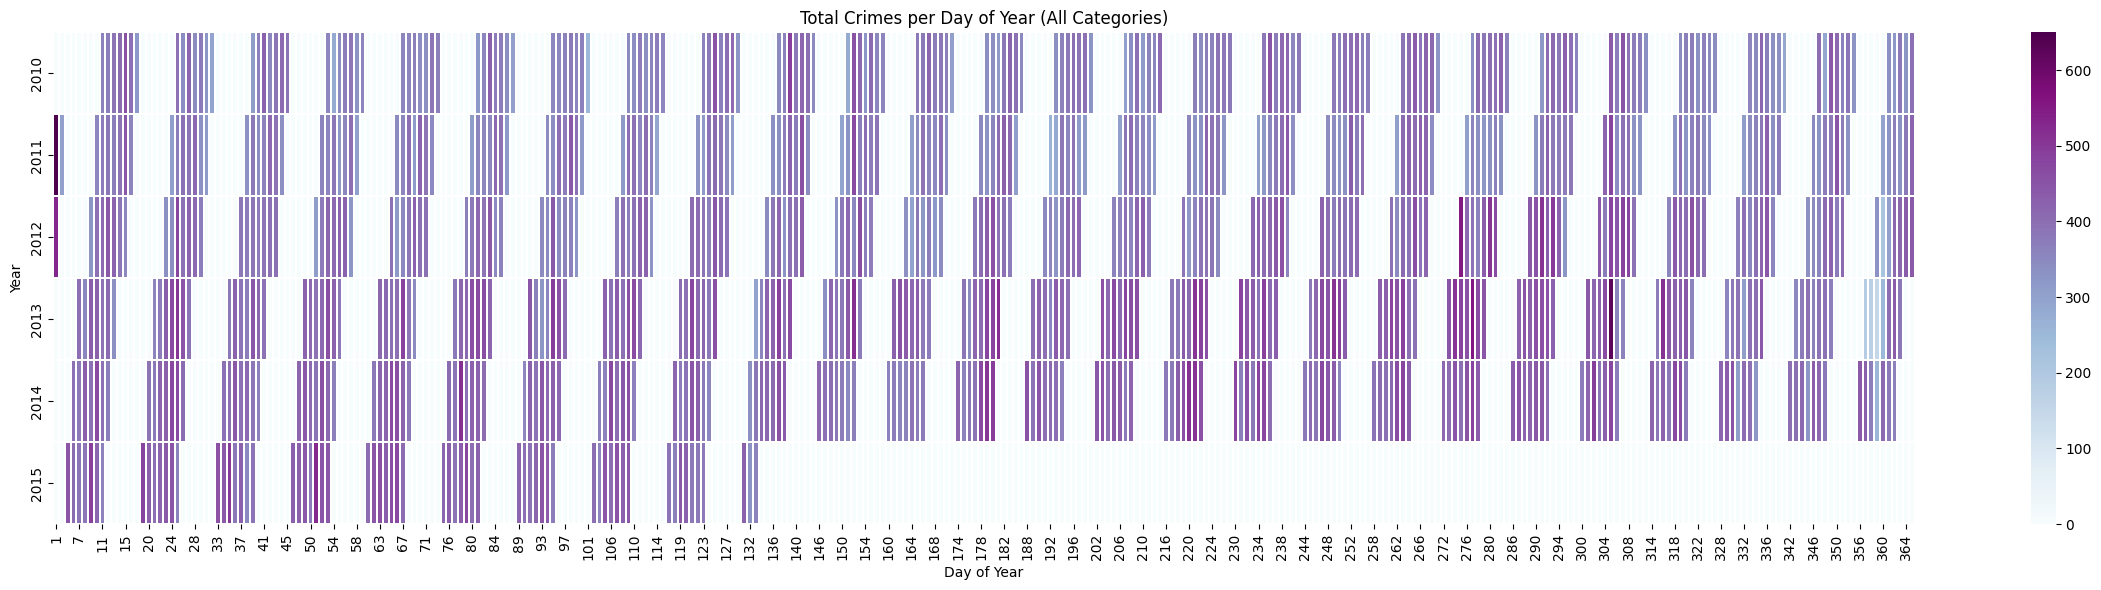

In [16]:
# Work on a copy to avoid modifying df directly
df_copy = df.copy()
df_copy['day_of_year'] = df_copy['date'].dt.dayofyear
df_copy['year'] = df_copy['date'].dt.year

# Count all crimes per (year, day_of_year)
crimes_per_day = (
    df_copy.groupby(['year', 'day_of_year'])
    .size()
    .rename('crime_count')
    .reset_index()
)

# Pivot for heatmap: rows=year, columns=day_of_year
heatmap_day_all = crimes_per_day.pivot(index='year', columns='day_of_year', values='crime_count').fillna(0)

plt.figure(figsize=(24, 6))
sns.heatmap(heatmap_day_all, cmap='BuPu', linewidths=0.2)
plt.title('Total Crimes per Day of Year (All Categories)')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

**[Mert Gunes]** There is a striking oscillating trend in the count of crimes where there seems to be zero or near-zero crimes every other week. This trend is too consistent to not be artificial. A quick check of the dataset description on Kaggle reveals that "the training set and test set rotate every week, meaning week 1,3,5,7... belong to test set, week 2,4,6,8 belong to training set." Therefore, it is highly likely that the dataset provided in this hackathon just happens to be one of the training or test sets at a certain point in the original competition. We can quickly check.

In [17]:
# Assign each row to its week (week starting Monday)
df_copy['week_start'] = df_copy['date'] - pd.to_timedelta(df_copy['date'].dt.weekday, unit='D')
df_copy['year'] = df_copy['week_start'].dt.year
df_copy['week_number'] = df_copy['week_start'].dt.isocalendar().week

# Count crimes per (year, week_number)
crimes_per_week = (
    df_copy
    .groupby(['year', 'week_number'], as_index=False)
    .size()
    .rename(columns={'size': 'crime_count'})
)

# Create all possible (year, week_number) pairs to ensure full coverage
all_years = np.arange(df_copy['year'].min(), df_copy['year'].max() + 1)
all_week_numbers = np.arange(1, 54)  # ISO weeks go up to 53
all_year_week = pd.MultiIndex.from_product(
    [all_years, all_week_numbers], names=['year', 'week_number']
).to_frame(index=False)

# Merge and fill missing with 0
calendar_week_df = all_year_week.merge(crimes_per_week, on=['year', 'week_number'], how='left').fillna(0)
calendar_week_df['crime_count'] = calendar_week_df['crime_count'].astype(int)

# Group by even/odd week numbers
calendar_week_df['week_type'] = np.where(calendar_week_df['week_number'] % 2 == 0, 'Even', 'Odd')

# Create the table: year as rows, week_type as columns, values as sum of crimes
crime_table = (
    calendar_week_df.groupby(['year', 'week_type'])['crime_count']
    .sum()
    .unstack(fill_value=0)
)

display(crime_table)

week_type,Even,Odd
year,,
2010,67497,0
2011,66194,0
2012,71201,0
2013,75606,0
2014,74766,0
2015,27584,0


**[Mert Gunes]** The table above clearly shows that the dataset we are working with is only from even numbered weeks, thus one of the split datasets from the original Kaggle competition.

#### **[Mert Gunes]** New question 2: Are there certain categories of crimes that are all marked as a theft?

In [18]:
# Group by 'category' and 'theft', then count the number of crimes in each group
crime_summary = df.groupby(['category', 'theft']).size().reset_index(name='crime_count')
crime_pivot = crime_summary.pivot(index='category', columns='theft', values='crime_count').replace(np.nan, 0)
display(crime_pivot)

theft,0,1
category,,
ARSON,633.0,0.0
ASSAULT,33303.0,0.0
BAD CHECKS,101.0,0.0
BRIBERY,158.0,0.0
BURGLARY,15307.0,0.0
DISORDERLY CONDUCT,1639.0,0.0
DRIVING UNDER THE INFLUENCE,1134.0,0.0
DRUG/NARCOTIC,18108.0,0.0
DRUNKENNESS,1848.0,0.0


**[Mert Gunes]** Only the Larceny / Theft category is marked as a theft in the dataset. Considering the category column was the original target of the dataset from Kaggle, the theft column is created based on category to simplify the target. Therefore, category should be omitted from our prediction model.

#### **[Mert Gunes]** New question 3: Are the thefts concentrated in a specific area or are they widespread?

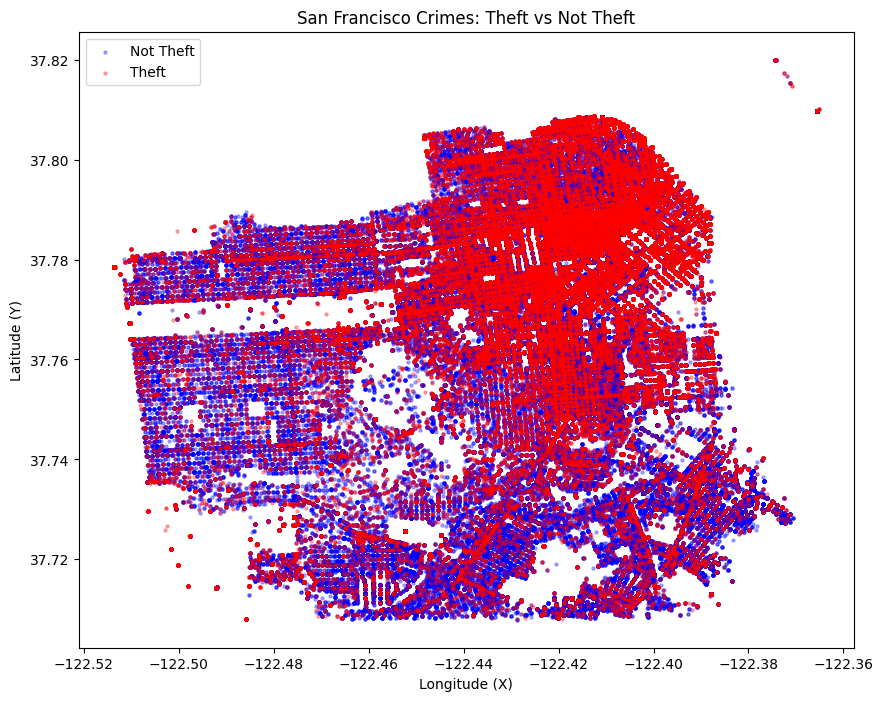

In [19]:
# Plot the crimes on a map of San Francisco with two distinct colors for theft (0 and 1)
plt.figure(figsize=(10, 8))

# Plot non-theft crimes (theft == 0)
plt.scatter(
    df.loc[df['theft'] == 0, 'x'],
    df.loc[df['theft'] == 0, 'y'],
    color='blue',
    alpha=0.3,
    s=5,
    label='Not Theft'
)

# Plot theft crimes (theft == 1)
plt.scatter(
    df.loc[df['theft'] == 1, 'x'],
    df.loc[df['theft'] == 1, 'y'],
    color='red',
    alpha=0.3,
    s=5,
    label='Theft'
)

plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('San Francisco Crimes: Theft vs Not Theft')
plt.legend()
plt.show()

**[Mert Gunes]** Observations from the map plot:
- There is a higher concentration of crimes marked as theft to the North-East of San Francisco.
- The large 'blank' areas between the points in the plot match green areas in the city map.
- There are certain streets or lanes that have a high concentration of theft along it while being surrounded by non-theft crime, of which most seem to be 'shooting' out of the red 'centre' at the top right. Therefore certain streets can have a high influence on predicting theft.

**[Mert Gunes]** Note that I will do more explorative data analysis when identifying additional features to engineer in the next section.

# Feature Engineering

Now we're going to create some new features for our model. We saw previously that we can create new features from our `date` feature. Create the following columns and drop the original `date` column:
- `n_days`: Number of days since first date
- `day`: The day of the year
- `weekday`: The day of the week
- `month`: The month of the year
- `year`: The year
- `hour`: The hour of the day
- `minute`: The minute of the hour


**[Mert Gunes]** Wherever possible, I will create custom scikit transformers for feature engineering to later incorporate to our scikit-learn pipeline. This will ensure reproducibility and streamlined workflow.

In [98]:
class DateTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to extract date features from a datetime column.
    Suitable for use in a ColumnTransformer.
    """
    feature_names = ['year', 'month', 'day', 'weekday', 'hour', 'minute', 'n_days']
    
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.iloc[:, 0]
        self.first_date_ = X.min()
        return self
    
    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.iloc[:, 0]
        check_is_fitted(self, 'first_date_')
        
        # Map feature names to their corresponding Series
        feature_map = {
            'year': X.dt.year,
            'month': X.dt.month,
            'day': X.dt.dayofyear,
            'weekday': X.dt.weekday,
            'hour': X.dt.hour,
            'minute': X.dt.minute,
            'n_days': (X - self.first_date_).dt.days
        }
        # Use feature_names to control order and selection
        return pd.DataFrame({name: feature_map[name] for name in self.feature_names}, index=X.index)
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names)
    
# Test the DateTransformer
date_transformer = DateTransformer()
date_transformer.fit(df[['date']])
date_features = date_transformer.transform(df[['date']])

# Compare the original data to the transformed features
print("Transformed date features:")
display(date_features.head())
display(date_features.describe())
print("Original date feature:")
display(df['date'].head())
print(f"Minimum date in the dataset: {date_transformer.first_date_}")

Transformed date features:


,year,month,day,weekday,hour,minute,n_days
0,2015,5,133,2,23,53,1948
1,2015,5,133,2,23,53,1948
2,2015,5,133,2,23,33,1948
3,2015,5,133,2,23,30,1948
4,2015,5,133,2,23,30,1948


,year,month,day,weekday,hour,minute,n_days
count,382848.000000,382848.000000,382848.000000,382848.000000,382848.000000,382848.000000,382848.000000
mean,2012.282585,6.327548,176.965365,3.021567,13.394796,20.426214,999.573614
std,1.554502,3.464483,105.812392,1.973577,6.609132,18.607311,561.675052
min,2010.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2011.000000,3.000000,82.000000,1.000000,9.000000,0.000000,518.000000
50%,2012.000000,6.000000,175.000000,3.000000,14.000000,20.000000,1022.000000
75%,2014.000000,9.000000,267.000000,5.000000,19.000000,34.000000,1486.000000
max,2015.000000,12.000000,365.000000,6.000000,23.000000,59.000000,1948.000000


Original date feature:


0   2015-05-13 23:53:00
1   2015-05-13 23:53:00
2   2015-05-13 23:33:00
3   2015-05-13 23:30:00
4   2015-05-13 23:30:00
Name: date, dtype: datetime64[ns]

Minimum date in the dataset: 2010-01-11 00:01:00


Make sure the features have been created correctly. What is the max and min of the new features? Is that what you expect?

Now let's make some extra features. The address column will be an issue since there are over 22000 unique values. Also we probably want to drop such sensitive data. Instead let's create:
- `is_block`: Take the value of True if the `address` feature has the word `Block` in
- `x_minus_y`: The difference between `x` and `y`
- `x_plus_y`: The sum of `x` and `y`


In [123]:
class AddressBlockTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.iloc[:, 0].str.contains(r'block', case=False, na=False).to_frame('is_block').astype(int)
    def get_feature_names_out(self, input_features=None):
        return ['is_block']
    
# Instantiate the AddressBlockTransformer
address_transformer = AddressBlockTransformer()

# Test the Address Transformer
address_features = address_transformer.transform(df[['address']])

# Compare the original data to the transformed features
print("Transformed address feature:")
display(address_features.head())
print("Original address feature:")
display(df['address'].head())

Transformed address feature:


,is_block
0,0
1,0
2,0
3,1
4,1


Original address feature:


0           OAK ST / LAGUNA ST
1           OAK ST / LAGUNA ST
2    VANNESS AV / GREENWICH ST
3     1500 Block of LOMBARD ST
4    100 Block of BRODERICK ST
Name: address, dtype: object

In [68]:
def add_coordinate_features(X):
    X = X.copy()
    X['x_minus_y'] = X['x'] - X['y']
    X['x_plus_y'] = X['x'] + X['y']
    return X

class CoordinateFeatureAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['x_minus_y'] = X['x'] - X['y']
        X['x_plus_y'] = X['x'] + X['y']
        return X[['x_minus_y', 'x_plus_y']]
    def get_feature_names_out(self, input_features=None):
        return ['x_minus_y', 'x_plus_y']

coordinate_feature_adder = CoordinateFeatureAdder()

# Test the Coordinate Feature Adder
coordinate_features = coordinate_feature_adder.transform(df)

# Compare the original data to the transformed features
print("Original coordinates:")
display(df[['x', 'y']].head())
print("Transformed coordinate features:")
display(coordinate_features.head())

Original coordinates:


,x,y
0,-122.425892,37.774599
1,-122.425892,37.774599
2,-122.424363,37.800414
3,-122.426995,37.800873
4,-122.438738,37.771541


Transformed coordinate features:


,x_minus_y,x_plus_y
0,-160.200490,-84.651293
1,-160.200490,-84.651293
2,-160.224777,-84.623949
3,-160.227868,-84.626123
4,-160.210279,-84.667196


## Any extra features

Add at least 2 extra features.

Potential features:

- Any special date fields
- Features based on past observations (e.g. crime in the same area during the past year)
- Converting categorical features (`pddistrict`) into numeric using target encoding
- Any other combination of features
- External features (from other datasets)

### **[Mert Gunes]** New Feature: Mean Thefts in Main Streets

**[Mert Gunes]** We previously created the addresstransformer which transforms the addrese feature to is_block feature. This reduces the cardinality of the ~ 20,000 unique addresses while removing sensitive data. However, as previouly obseverd in our map plot, some streets or lanes seem to have a high concentration of theft in an otherwise 'theftless area'. We should find a feature that captures this trend.

In [23]:
df['address'].sample(30)

123099           SILVER AV / SAN BRUNO AV
274062         100 Block of FORESTSIDE AV
371069               0 Block of MIGUEL ST
16450                0 Block of HOWARD ST
152697             GEARY BL / FILLMORE ST
334098               ANNIE ST / JESSIE ST
323942            1300 Block of WAWONA ST
346616            800 Block of LINCOLN WY
306220              600 Block of ELLIS ST
297361    BROTHERHOOD WAY / THOMASMORE WY
156581            1800 Block of POWELL ST
266410            1600 Block of PIERCE ST
267691         1200 Block of POWHATTAN AV
284918           1000 Block of POTRERO AV
330302           400 Block of VALENCIA ST
74538            600 Block of OFARRELL ST
235568                0 Block of WILLS ST
285034              OCEAN AV / CAPITOL AV
213668           5400 Block of MISSION ST
128149              3000 Block of 24TH ST
184757              500 Block of ELLIS ST
28082              200 Block of LARKIN ST
320338           2800 Block of OAKDALE AV
351436              POLK ST / OFAR

In [24]:
# Count how many addresses contain the words " of ", how many contain " / ", and how many others
of_count = df['address'].str.contains(r'\bof\b', case=False, na=False).sum()
slash_count = df['address'].str.contains(r'/', case=False, na=False).sum()
other_count = df['address'][~df['address'].str.contains(r'\bof\b|/', case=False, na=False)].count()

print("Address patterns count:")
print(f"of: {of_count}")
print(f"/: {slash_count}")
print(f"other: {other_count}")

Address patterns count:
of: 277332
/: 105519
other: 0


**[Mert Gunes]** Address values are always made of two parts with either a " / " or a " of "delimiter. What cardinality are we left with if we only look at the address after each delimiter?

In [25]:
# Create a column that takes the second part of the address after " of " or " / "
def extract_address_part(address):
    if pd.isna(address):
        return np.nan
    parts = address.split(' of ', 1) if ' of ' in address else address.split('/', 1)
    return parts[1].strip() if len(parts) > 1 else np.nan

print(f"Unique values of original address: {df['address'].nunique()}")
print(f"Unique values of extracted address part: {df['address'].apply(extract_address_part).nunique()}")

df['address'].apply(extract_address_part).sample(15)

Unique values of original address: 19538
Unique values of extracted address part: 1799


236684    LEAVENWORTH ST
43493            15TH ST
58257         INDIANA ST
10854           MASON ST
69281             4TH ST
317138    LEAVENWORTH ST
110449          LOBOS ST
331154          JONES ST
360880           FELL ST
261974            4TH ST
212482     YERBABUENA AV
131993          GEARY BL
233154         MARKET ST
348111        LOMBARD ST
355083        JERROLD AV
Name: address, dtype: object

**[Mert Gunes]** The cardinality has greatly reduced from ~20,000 to ~1800, but it still too high for standard encoding methods. Plus, we still need to anonymize it remove sensitive data. The solution is target encoding; we can encode the extracted address part with its mean theft value using the training data. This will both transform the categorical feature to a numeric feature and remove sensitive data.

In [117]:
class MainStreetTargetEncoder(BaseEstimator, TransformerMixin):
    """
    Extracts the address part after ' of ' or '/' and target encodes it using the mean of the target.
    Designed for use in a ColumnTransformer (expects a single-column DataFrame or Series).
    """
    def fit(self, X, y):
        address_part = X.squeeze().apply(self._extract_address_part)
        self.target_means_ = y.groupby(address_part).mean()
        self.global_mean_ = y.mean()
        return self

    def transform(self, X):
        address_part = X.squeeze().apply(self._extract_address_part)
        encoded = address_part.map(self.target_means_).fillna(self.global_mean_)
        return encoded.to_frame('mean_thefts')
    
    def get_feature_names_out(self, input_features=None):
        return ['mean_thefts']

    @staticmethod
    def _extract_address_part(address):
        if pd.isna(address):
            return np.nan
        if ' of ' in address:
            parts = address.split(' of ', 1)
        elif '/' in address:
            parts = address.split('/', 1)
        else:
            return np.nan
        return parts[1].strip() if len(parts) > 1 else np.nan
    
# Test the AddressPartTargetEncoder
main_street_mean_thefts_adder = MainStreetTargetEncoder()
main_street_mean_thefts_adder.fit(df[['address']], df['theft'])
main_street_mean_thefts_adder.transform(df[['address']])


,mean_thefts
0,0.391445
1,0.391445
2,0.272048
3,0.360925
4,0.267890
...,...
382843,0.373659
382844,0.071174
382845,0.107843
382846,0.273629


### **[Mert Gunes]** New Features: Thefts Previously (Not) Caught

**[Mert Gunes]** In later steps, the features 'descript' and 'resolution' will be omitted from the prediction model as they are not available at the time of prediction. However, they can prove valuable if we could create features based on them from *past* data. The original competition on Kaggle also provides these columns in the train data but not in the test data, implying that we can learn from them but not have them in testing (as would be case when predicting a new crime). If a theft crime has not been resolved i.e. the thief has not been caught, it is more likely to be repeated in the same area. Therefore, we can create a feature that counts the number of unresolved vs resolved thefts from a previous time. We must take care to always look at past data and avoid target leakege.

In [27]:
# Check the resolution of theft crimes
df[df['theft'] == 1]['resolution'].value_counts()

resolution
NONE                                      78486
ARREST, BOOKED                             3619
ARREST, CITED                              2221
JUVENILE CITED                              336
UNFOUNDED                                   265
JUVENILE BOOKED                             141
EXCEPTIONAL CLEARANCE                       130
COMPLAINANT REFUSES TO PROSECUTE            107
JUVENILE ADMONISHED                          75
DISTRICT ATTORNEY REFUSES TO PROSECUTE       46
NOT PROSECUTED                               26
PROSECUTED BY OUTSIDE AGENCY                 18
PSYCHOPATHIC CASE                            12
LOCATED                                       8
JUVENILE DIVERTED                             7
CLEARED-CONTACT JUVENILE FOR MORE INFO        4
Name: count, dtype: int64

**[Mert Gunes]** Most thefts' resolution is 'NONE', which presumably means that the thief has not been caught. On the other hand, The resolution 'ARREST, BOOKED' is the second most common resolution, which means that the thief has been caught; there are similar resolutions but for JUVENILE. The other resolutions are more nuanced situations but are also rare. These resolutions can be grouped based on the context. We will use a simple grouping for now where if resolution = 'none' then 'not_caught', else 'caught'. Next, I want to identify what 'past date' we should use by exploring our data.

C:\Users\N10389\AppData\Local\Temp\ipykernel_3168\2059856026.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(monthly.index.astype(str), rotation=45)


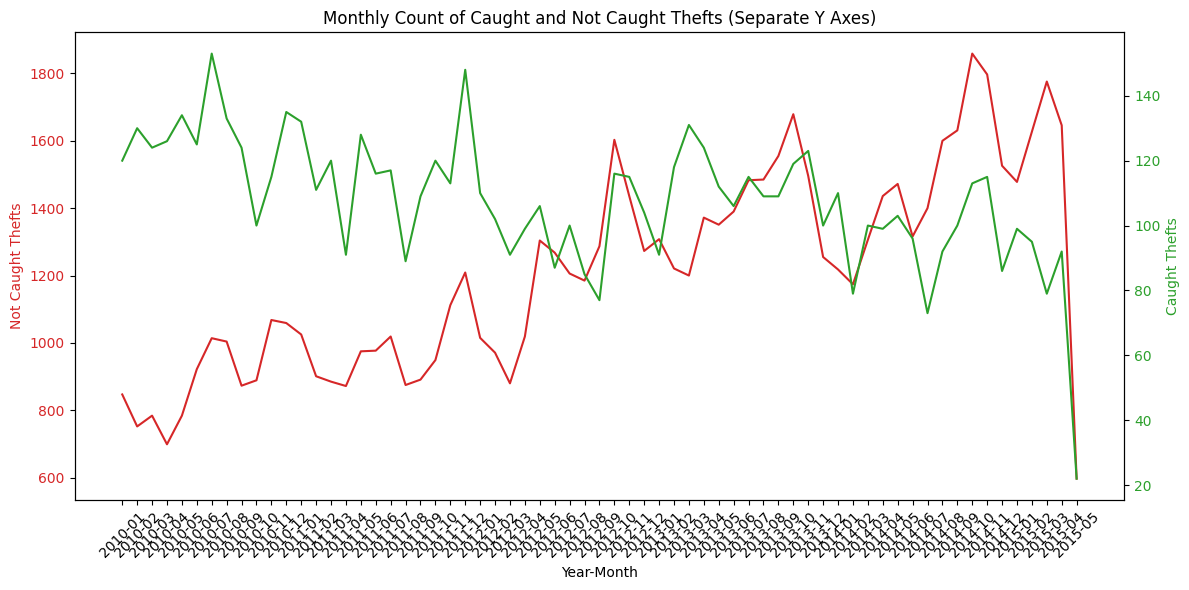

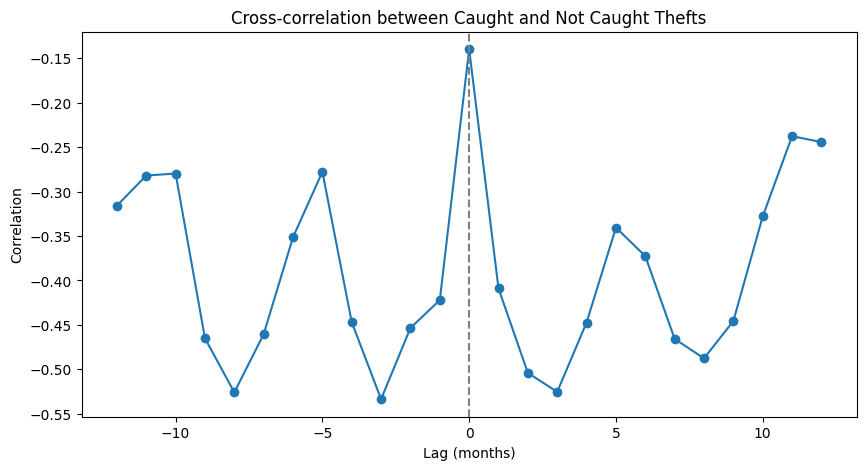

In [28]:
# Prepare year-month and caught/not_caught counts
df_copy = df.copy()
df_copy['year_month'] = df_copy['date'].dt.to_period('M')
thefts = df_copy[df_copy['theft'] == 1].copy()
thefts['not_caught'] = (thefts['resolution'].str.upper() == 'NONE').astype(int)
thefts['caught'] = (thefts['resolution'].str.upper() != 'NONE').astype(int)
monthly = thefts.groupby('year_month').agg({'not_caught': 'sum', 'caught': 'sum'}).sort_index()

# Plot with separate y axes
fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = 'tab:red'
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Not Caught Thefts', color=color1)
ax1.plot(monthly.index.astype(str), monthly['not_caught'], color=color1, label='Not Caught Thefts')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticklabels(monthly.index.astype(str), rotation=45)

ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('Caught Thefts', color=color2)
ax2.plot(monthly.index.astype(str), monthly['caught'], color=color2, label='Caught Thefts')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Monthly Count of Caught and Not Caught Thefts (Separate Y Axes)')
fig.tight_layout()
plt.show()

# Assume 'monthly' DataFrame is already created as in your previous code
caught = monthly['caught']
not_caught = monthly['not_caught']

# Compute cross-correlation for a range of lags
max_lag = 12  # e.g., up to 12 months lead/lag
lags = np.arange(-max_lag, max_lag + 1)
corrs = [caught.corr(not_caught.shift(lag)) for lag in lags]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(lags, corrs, marker='o')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')
plt.title('Cross-correlation between Caught and Not Caught Thefts')
plt.axvline(0, color='gray', linestyle='--')
plt.show()

**[Mert Gunes]** The trend of not caught and caught thefts somewhat follow each other, probably based on the the total thefts. Looking at the cross-correlation graph, there are 'mirrored peaks' for both the lead and the lag, making it difficult to make any meaningful assumptions. Instead of monthly, let us check quartlery next.

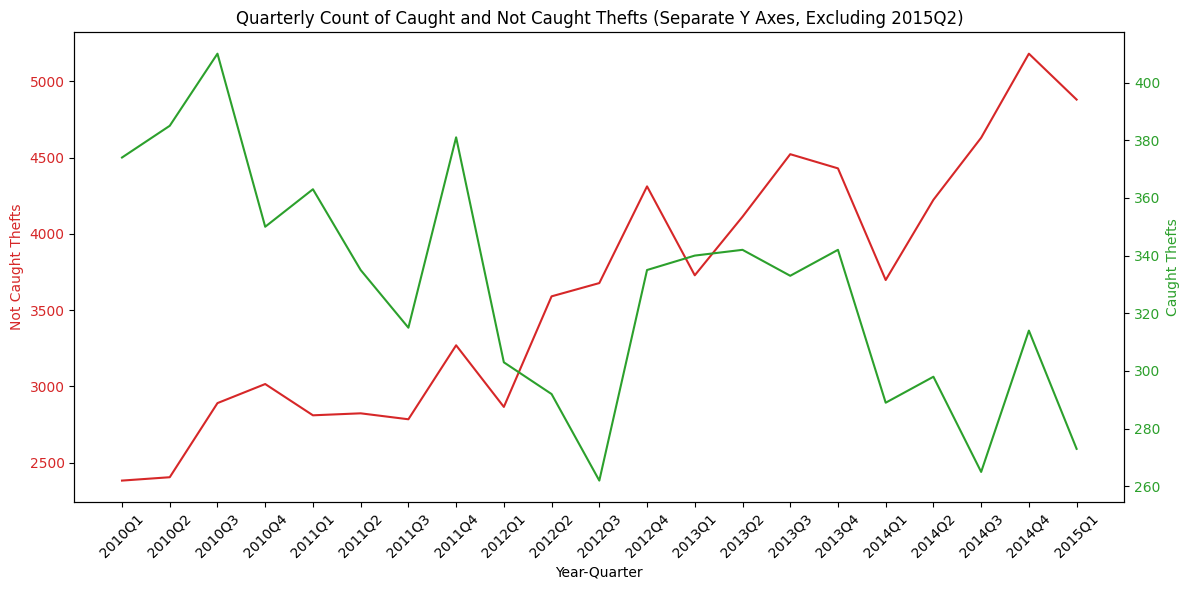

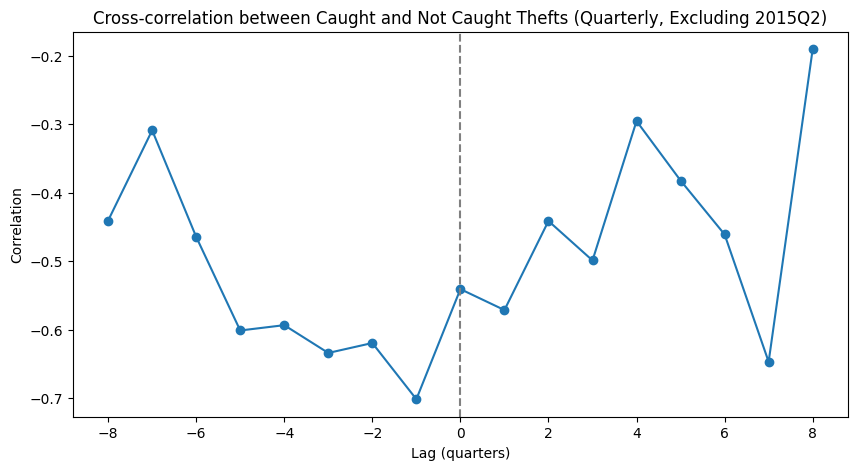

In [29]:
# --- Plot with calendar quarter as x axis, no small multiples, EXCLUDING 2015Q2 which does not have a 'full quarter' of data ---
thefts['year_quarter'] = thefts['date'].dt.to_period('Q').astype(str)
quarterly = thefts.groupby('year_quarter').agg({'not_caught': 'sum', 'caught': 'sum'}).sort_index()

# Exclude 2015Q2
quarterly = quarterly[quarterly.index != '2015Q2']

fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = 'tab:red'
ax1.set_xlabel('Year-Quarter')
ax1.set_ylabel('Not Caught Thefts', color=color1)
ax1.plot(quarterly.index, quarterly['not_caught'], color=color1, label='Not Caught Thefts')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(quarterly.index[::max(1, len(quarterly)//12)])
ax1.set_xticklabels(quarterly.index[::max(1, len(quarterly)//12)], rotation=45)

ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('Caught Thefts', color=color2)
ax2.plot(quarterly.index, quarterly['caught'], color=color2, label='Caught Thefts')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Quarterly Count of Caught and Not Caught Thefts (Separate Y Axes, Excluding 2015Q2)')
fig.tight_layout()
plt.show()

# Compute cross-correlation for quarterly data (excluding 2015Q2)
caught_q = quarterly['caught']
not_caught_q = quarterly['not_caught']

max_lag_q = 8  # up to 8 quarters lead/lag (2 years)
lags_q = np.arange(-max_lag_q, max_lag_q + 1)
corrs_q = [caught_q.corr(not_caught_q.shift(lag)) for lag in lags_q]

plt.figure(figsize=(10, 5))
plt.plot(lags_q, corrs_q, marker='o')
plt.xlabel('Lag (quarters)')
plt.ylabel('Correlation')
plt.title('Cross-correlation between Caught and Not Caught Thefts (Quarterly, Excluding 2015Q2)')
plt.axvline(0, color='gray', linestyle='--')
plt.show()

**[Mert Gunes]** We can see a peak at lag -1 quarter with a correlation value of -0.7. This means that the number of "caught" thefts in a given quarter is strongly negatively correlated with the number of "not caught" thefts in the following quarter (because negative lag means "future" relative to the reference series). In other words, if there are many caught thefts this quarter, there tend to be fewer not caught thefts next quarter, and vice versa. This could suggest that effective law enforcement (more caught thefts) in one quarter is associated with fewer unresolved thefts in the next quarter, or that periods of high unresolved thefts are followed by periods of more thefts being resolved, possibly due to increased police activity or investigations catching up. Either way, it will be helpful to create a feature checking caught vs not caught thefts from the previous quarter.

In [108]:
class TheftResolutionLastQuarterTransformer(BaseEstimator, TransformerMixin):
    """
    For each year-quarter, computes the number of thefts with resolution 'NONE' (not caught)
    and with other resolutions (caught) in the previous year-quarter.
    Adds two features: 'theft_not_caught_last_quarter' and 'theft_caught_last_quarter'.
    Assumes input DataFrame has columns: 'date', 'theft', 'resolution'.
    """
    def fit(self, X, y):
        X = X.copy()
        if y is None:
            raise ValueError("Target y (theft) must be provided for fitting.")
        # Add 'theft' from y
        X['theft'] = y.values
        # Extract year-quarter
        X['year_quarter'] = X['date'].dt.to_period('Q')
        # Compute counts for each year-quarter
        thefts = X[X['theft'] == 1].copy()
        thefts['not_caught'] = (thefts['resolution'].str.upper() == 'NONE').astype(int)
        thefts['caught'] = (thefts['resolution'].str.upper() != 'NONE').astype(int)
        grouped = thefts.groupby('year_quarter').agg({
            'not_caught': 'sum',
            'caught': 'sum'
        })
        # Calculate means for fallback
        self.mean_not_caught_ = grouped['not_caught'].mean()
        self.mean_caught_ = grouped['caught'].mean()
        # Ensure all quarters are represented and sorted by year-quarter
        all_quarters = pd.period_range(grouped.index.min(), grouped.index.max(), freq='Q')
        grouped = grouped.reindex(all_quarters, fill_value=np.nan)
        grouped = grouped.sort_index(ascending=True)
        # Store for transform
        self.last_quarter_stats_ = grouped.shift(1)
        self.last_quarter_stats_.index = self.last_quarter_stats_.index.astype(str)
        return self

    def transform(self, X):
        X = X.copy()
        X['year_quarter'] = X['date'].dt.to_period('Q').astype(str)
        # Map stats from previous quarter, fill missing with mean
        X['not_caught'] = X['year_quarter'].map(self.last_quarter_stats_['not_caught']).fillna(self.mean_not_caught_).astype(int)
        X['caught'] = X['year_quarter'].map(self.last_quarter_stats_['caught']).fillna(self.mean_caught_).astype(int)
        return X[['not_caught', 'caught']]

    def get_feature_names_out(self, input_features=None):
        return ['not_caught', 'caught']

# Example usage:
theft_resolution_feature_adder = TheftResolutionLastQuarterTransformer()
theft_resolution_feature_adder.fit(df[['date', 'resolution']], df['theft'])
features = theft_resolution_feature_adder.transform(df)
display(features.sample(20))

,not_caught,caught
166202,4312,335
82260,3698,289
186323,3678,262
282346,2824,335
129517,4113,342
312787,3016,350
217128,2866,303
50943,4224,298
332520,2891,410
332806,2891,410


# Prepare the data for sci-kit learn

First we need to seperate our features and our labels.

Note that two features will need to be dropped:
- `descript` - detailed description of the crime incident, therefore a more detailed version of our **target feature**
- `resolution` - how the crime incident was resolved, therefore created after our target was defined, and cannot be used to predict a new crime

Create X and y. 

- X should have the following features (plus whatever bespoke ones you've created): 
```python
'pddistrict', 'x', 'y','n_days', 'day', 'dayofweek', 'month', 'year', 'hour', 'minute', 'x_minus_y', 'x_plus_y', 'is_block'
```
- y should only have one feature: `theft`

**[Mert Gunes]** I opted to create function and custom transformers using scikit-learn instead of transforming the data (e.g. with Pandas) up till this point in order to create a compherensive scikit Pipeline. Therefore, I will refer to the original columns of the dataset when defining X and y instead of the engineered features. Furthermore, we require the original column 'resolution' in order to create a fit during training only, but must prevent data leakage by not including it in the test set.

In [31]:
# Print list of original columns of the dataset
print("Original columns in the dataset:")
print(df.columns.tolist())

Original columns in the dataset:
['date', 'category', 'descript', 'pddistrict', 'resolution', 'address', 'x', 'y', 'theft']


In [32]:
training_only_cols = ['resolution']
drop_cols = ['category', 'descript']
target = 'theft'

X = df.drop(columns = drop_cols + [target])
y = df[target]

Now let's look at which features are categorical (`object` data types):

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382848 entries, 0 to 382847
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        382848 non-null  datetime64[ns]
 1   category    382848 non-null  object        
 2   descript    382848 non-null  object        
 3   pddistrict  382848 non-null  object        
 4   resolution  382848 non-null  object        
 5   address     382848 non-null  object        
 6   x           382848 non-null  float64       
 7   y           382848 non-null  float64       
 8   theft       382848 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 26.3+ MB


Looks like we have some non-numeric data that we will need to change! (`pddistrict`, `address`)

First let's split into train and test:

In [100]:
# Remove training_only_cols before splitting
X_base = X.drop(columns=training_only_cols)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_base, y, test_size=0.25, random_state=42, stratify=y
)

# Add training_only_cols back to X_train if needed
for col in training_only_cols:
    X_train[col] = X.loc[X_train.index, col]

# Add training_only_cols to X_test with NaN values
for col in training_only_cols:
    X_test[col] = np.nan

# Build a base-line model

Choose a model to build and use the raw data to build a base-line model. Drop all missing rows.

How does your model perform? How do other algorithms perform? Why are some better than others?

In [36]:
# Display the distribution of the target variable
print("Distribution of target variable 'theft':")
print(df['theft'].value_counts(normalize=True))

Distribution of target variable 'theft':
theft
0    0.776671
1    0.223329
Name: proportion, dtype: float64


**[Mert Gunes]** The simplest model would be to always predict the most likely outcome. In this case, you would always predict theft, which would yield a model accuracy of ~78%. Note that our data is moderately imbalanced and we should use metrics other than accuracy and use techniques such as class weighting. Let's first set up our scikit-learn Pipeline to include all our tranformations before building a machine learning model.

# Encoding

You can use one-hot encoding to convert the categorical features, or just drop them for now while building a baseline model.


In [191]:
onehot_encoder = OneHotEncoder(sparse_output=False)

### Add ColumnTransformer

Let's include `ColumnTransformer()` so that we can apply the onehotencoder to only the categorical columns.

**[Mert Gunes]** The ColumnTransformer() that I am creating here will include all the previously created custom transformers as well as the onehotencoder. Also, 'pddistrict' is the only feature remaining after all other transformations that needs to be onehot encoded.

In [192]:
# Create a ColumnTransformer
transformations = ColumnTransformer(
    transformers=[
        ('date', date_transformer, ['date']),
        ('address', address_transformer, ['address']),
        ('coordinates', coordinate_feature_adder, ['x', 'y']),
        ('main_street', main_street_mean_thefts_adder, ['address']),
        ('thefts_last_quarter', theft_resolution_feature_adder, ['date', 'resolution']),
        ('onehot', onehot_encoder, ['pddistrict'])
    ],
    remainder='passthrough'
)
transformations.set_output(transform='pandas')

# Fit and test transformations on the training data
transformations.fit(X_train, y_train)
display(transformations.transform(X_train).head())

# Test transformations on the test data
display(transformations.transform(X_test).head())

,date__year,date__month,date__day,date__weekday,date__hour,date__minute,date__n_days,address__is_block,coordinates__x_minus_y,coordinates__x_plus_y,...,onehot__pddistrict_BAYVIEW,onehot__pddistrict_CENTRAL,onehot__pddistrict_INGLESIDE,onehot__pddistrict_MISSION,onehot__pddistrict_NORTHERN,onehot__pddistrict_PARK,onehot__pddistrict_RICHMOND,onehot__pddistrict_SOUTHERN,onehot__pddistrict_TARAVAL,onehot__pddistrict_TENDERLOIN
269764,2011,9,262,0,2,0,616,1,-160.178489,-84.716990,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163065,2013,3,78,1,18,0,1163,1,-160.214096,-84.638059,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
86907,2014,3,78,2,15,0,1528,1,-160.196767,-84.693211,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
88029,2014,3,68,6,20,15,1518,1,-160.116750,-84.647745,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
379714,2010,1,26,1,7,0,15,1,-160.140038,-84.678615,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,date__year,date__month,date__day,date__weekday,date__hour,date__minute,date__n_days,address__is_block,coordinates__x_minus_y,coordinates__x_plus_y,...,onehot__pddistrict_BAYVIEW,onehot__pddistrict_CENTRAL,onehot__pddistrict_INGLESIDE,onehot__pddistrict_MISSION,onehot__pddistrict_NORTHERN,onehot__pddistrict_PARK,onehot__pddistrict_RICHMOND,onehot__pddistrict_SOUTHERN,onehot__pddistrict_TARAVAL,onehot__pddistrict_TENDERLOIN
191309,2012,10,304,1,9,15,1023,1,-160.178825,-84.627984,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
196157,2012,10,279,4,12,36,998,1,-160.201029,-84.631169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
249768,2011,12,365,5,21,7,719,1,-160.202377,-84.606144,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5867,2015,4,105,2,12,0,1920,1,-160.199167,-84.702603,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
178365,2012,12,365,6,1,0,1084,1,-160.178825,-84.627984,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Create a pipeline

Now that we know we have to transform our data using a sklearn transformer, it would be good to package this up into a pipeline.

Let's build a RandomForest to begin with.

In [143]:
# Define the base model
base_model = RandomForestClassifier(class_weight='balanced',
                                    max_depth=5,
                                    random_state=123,
                                    )

base_pipeline = Pipeline(steps=[
    ('transformations', transformations),
    ('model', base_model)
])

# Train the model based on the training data
base_pipeline.fit(X_train, y_train)

# Display the pipeline steps 
base_pipeline

Pipeline(steps=[('transformations',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date', DateTransformer(),
                                                  ['date']),
                                                 ('address',
                                                  AddressBlockTransformer(),
                                                  ['address']),
                                                 ('coordinates',
                                                  CoordinateFeatureAdder(),
                                                  ['x', 'y']),
                                                 ('main_street',
                                                  MainStreetTargetEncoder(),
                                                  ['address']),
                                                 ('thefts_last_quarter',
                                                  TheftResolutionLastQuarterTransformer(),
                                                  ['date', 'resolution']),
                                                 ('onehot', OneHotEncoder(),
                                                  ['pddistrict'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        random_state=123))])

In [171]:
y_train_base_pred = base_pipeline.predict(X_train)
print("Training Accuracy Score:", accuracy_score(y_train, y_train_base_pred), "\n")

y_test_base_pred = base_pipeline.predict(X_test)
print("Test Accuracy Score:", accuracy_score(y_test, y_test_base_pred))

Training Accuracy Score: 0.6379276719046026 

Test Accuracy Score: 0.6350614343029087


**[Mert Gunes]** Our base machine learning model has an accuracy of ~64% on both the training and test datasets. This is significantly lower than simply predicting the more probable outcome with an accuracy of 78%. Therefore our base model has not beaten the baseline and definitely needs hypertuning.

# Gridsearch

Now let's see if we can hypertune these parameters!

In [174]:
# Create a parameter grid for hyperparameter tuning for RandomForestClassifier
param_grid = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [5, 10]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
    base_pipeline,
    param_grid,
    cv=2,
    scoring='accuracy'
)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('transformations',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('date',
                                                                         DateTransformer(),
                                                                         ['date']),
                                                                        ('address',
                                                                         AddressBlockTransformer(),
                                                                         ['address']),
                                                                        ('coordinates',
                                                                         CoordinateFeatureAdder(),
                                                                         ['x',
                                                                          'y']),
                                                                        ('main_street',
                                                                         MainStreetTargetEncoder(),
                                                                         ['address']),
                                                                        ('thefts_last_quarter',
                                                                         TheftResolutionLastQuarterTransformer(),
                                                                         ['date',
                                                                          'resolution']),
                                                                        ('onehot',
                                                                         OneHotEncoder(),
                                                                         ['pddistrict'])])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_depth=5,
                                                               random_state=123))]),
             param_grid={'model__max_depth': [5, 10],
                         'model__n_estimators': [50, 100]},
             scoring='accuracy')

In [175]:
# Display the best parameters and the best score
display(pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score').head())
print("Best parameters found:")
print(grid_search.best_params_)
print("Best cross-validation score:")
print(grid_search.best_score_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
3,13.172148,0.578787,1.537471,0.127961,10,100,"{'model__max_depth': 10, 'model__n_estimators'...",0.672260,0.678389,0.675325,0.003065,1
2,6.465295,0.480273,1.070828,0.179823,10,50,"{'model__max_depth': 10, 'model__n_estimators'...",0.672309,0.674969,0.673639,0.001330,2
1,7.383645,0.388162,0.995481,0.055299,5,100,"{'model__max_depth': 5, 'model__n_estimators':...",0.635204,0.638067,0.636636,0.001431,3
0,3.763116,0.008022,0.634942,0.007641,5,50,"{'model__max_depth': 5, 'model__n_estimators':...",0.625571,0.628176,0.626874,0.001303,4


Best parameters found:
{'model__max_depth': 10, 'model__n_estimators': 100}
Best cross-validation score:
0.6753245848657082


In [177]:
# Instantiate the best model from grid search
hypertuned_model = grid_search.best_estimator_

**[Mert Gunes]** After hypertuning, the accuracy has gone up from 64% to 68% which is a good improvement but still the result falls well below the mark of the baseline 78%. Next steps should be to reiterate on feature engineering or experiment with other models. Since our target is binary, I will try logistic regression. Note that I will also add a step to standardize the dataset before passing it to the logistic regression model.

In [201]:
# Create a logistic regression model with class_weight balanced
logreg_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=123)

# Build a pipeline with transformations, standardization, and logistic regression
logreg_pipeline = Pipeline([
    ('transformations', transformations),
    ('scaler', StandardScaler()),  # Standardize features before logistic regression
    ('model', logreg_model)
])

# Hypertune logistic regression parameters with a short grid search
param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs']
}
logreg_grid = GridSearchCV(logreg_pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
logreg_grid.fit(X_train, y_train)

print("Best Logistic Regression parameters:", logreg_grid.best_params_)
print("Best cross-validation score:", logreg_grid.best_score_)

# Evaluate the best model
best_logreg = logreg_grid.best_estimator_
y_test_pred_logreg = best_logreg.predict(X_test)
print("Test Classification Report (Logistic Regression):")
print(classification_report(y_test, y_test_pred_logreg))
print("Test Accuracy Score (Logistic Regression):", accuracy_score(y_test, y_test_pred_logreg))

Best Logistic Regression parameters: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best cross-validation score: 0.6403759890783461
Test Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.86      0.64      0.73     74337
           1       0.34      0.64      0.44     21375

    accuracy                           0.64     95712
   macro avg       0.60      0.64      0.59     95712
weighted avg       0.74      0.64      0.67     95712

Test Accuracy Score (Logistic Regression): 0.6393137746573052


**[Mert Gunes]** A hypertuned logistic regression model only resulted in an accuracy of ~64% which does not beat our hypertuned Random Forest classifier. In the big picture, both models are performing poorly and further iterations would be required at this point. For the scope of this hackathon and to stay within its timeframe, I will proceed to the next steps.

# Metrics

So far we've looked at Accuracy Score, F1-Score, Recall and Precision. Can you create an output that reports these metrics?

In [178]:
y_train_pred = hypertuned_model.predict(X_train)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))
print("Training Accuracy Score:", accuracy_score(y_train, y_train_pred), "\n")

y_test_pred = hypertuned_model.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))

Training Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.77    223010
           1       0.39      0.72      0.50     64126

    accuracy                           0.68    287136
   macro avg       0.64      0.70      0.64    287136
weighted avg       0.78      0.68      0.71    287136

Training Accuracy Score: 0.6836760280842528 

Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.66      0.76     74337
           1       0.37      0.70      0.49     21375

    accuracy                           0.67     95712
   macro avg       0.63      0.68      0.62     95712
weighted avg       0.77      0.67      0.70     95712

Test Accuracy Score: 0.6721309762621197


# Feature Selection

Now that you have your model, can you look at the feature importance to reduce the features in your model and still maintain the score?

To access the feature importance you must:

1. access the model from the pipeline: `pipeline['model']`
2. access the feature importances attribute using `.feature_importances_`

You can then plot this against the feature names (`.get_feature_names_`)

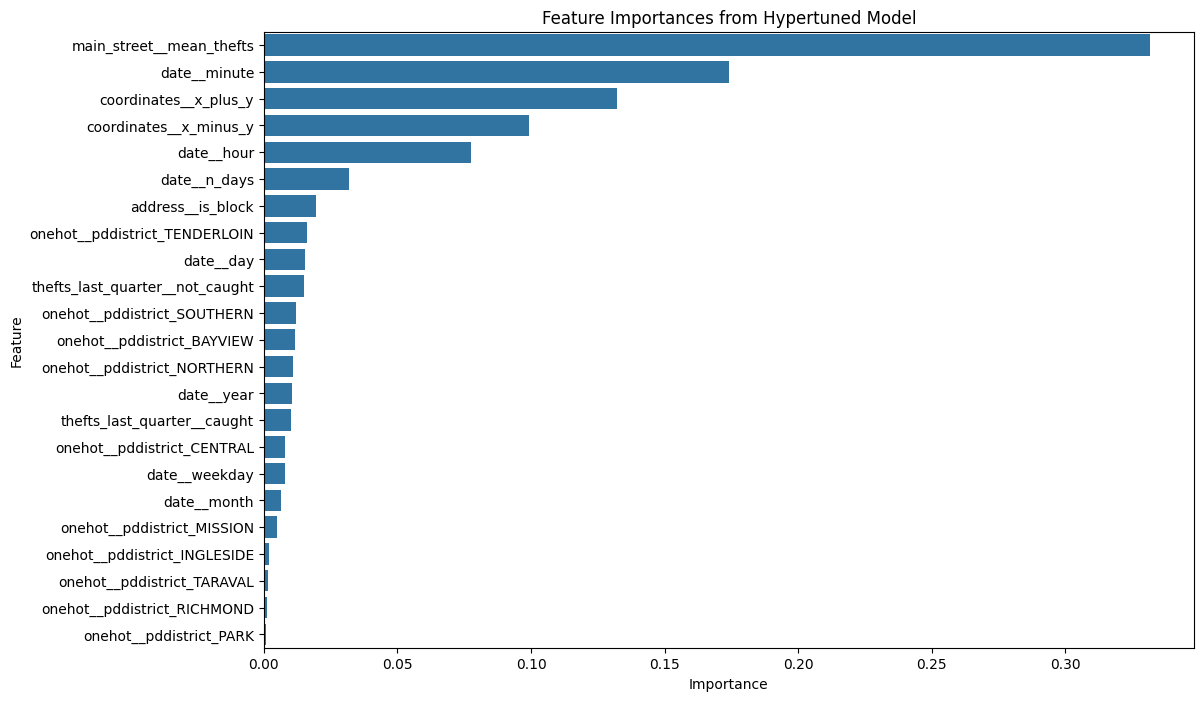

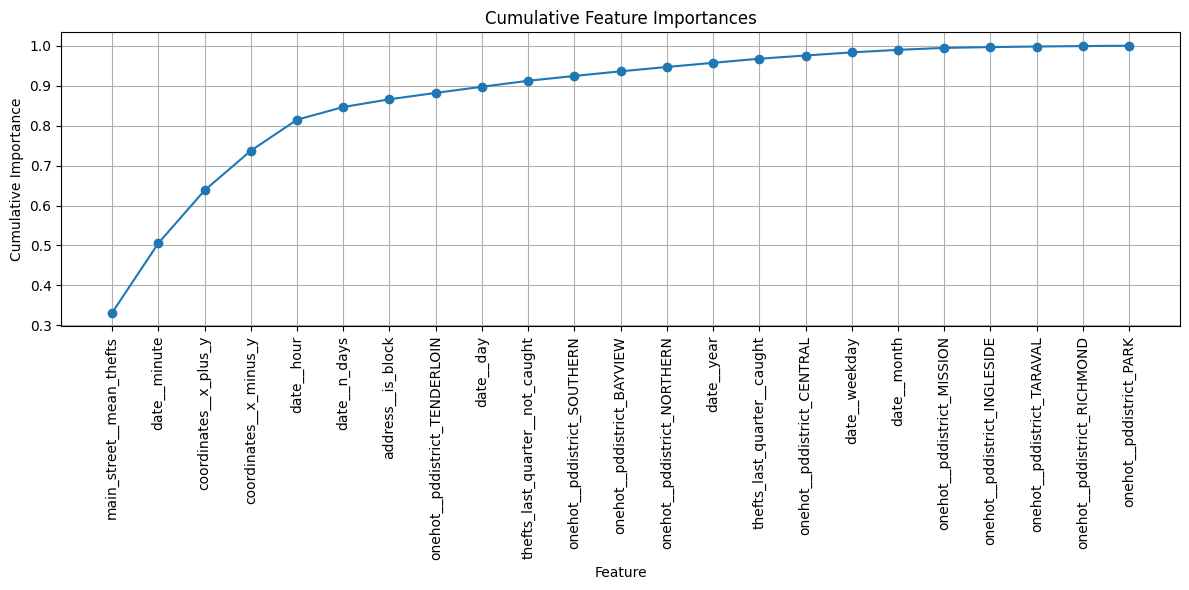

In [184]:
# Plot the feature importances using the feature names from the transformations
feature_names = hypertuned_model['transformations'].get_feature_names_out()
importances = hypertuned_model['model'].feature_importances_

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df)
plt.title('Feature Importances from Hypertuned Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Plot the cumulative feature importances
cumulative_importances = feature_importances_df['importance'].cumsum()
plt.figure(figsize=(12, 6))
plt.plot(feature_importances_df['feature'], cumulative_importances, marker='o')
plt.title('Cumulative Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Cumulative Importance')
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

**[Mert Gunes]** The most important feature is main_street__main_thefts, contributing to about a third of the model's decision-making process. I had engineered this feature after spotting a trend from the map plot during the data exploration; this highlights the importance of EDA. Also, looking at the cumulative feature importances, there is an 'elbow' at the top 5th feature (date__hour) with a cumulative importance of 80%. Can these top 5 features alone create a model with a comparable prediction performance?

## Rebuild the model using fewer characteristics

In [202]:
# Get top 5 important features from previous feature_importances_df
top_features = feature_importances_df['feature'].head(5).tolist()
print("Top 5 features:", top_features)

# Create a new ColumnTransformer that selects only the top 5 features after transformation
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.features]
    def get_feature_names_out(self, input_features=None):
        return self.features

# Build a new pipeline using only the top 5 features
feature_selector = FeatureSelector(top_features)

reduced_pipeline = Pipeline([
    ('transformations', transformations),
    ('select_top', feature_selector),
    ('model', RandomForestClassifier(
        n_estimators=grid_search.best_params_['model__n_estimators'],
        max_depth=grid_search.best_params_['model__max_depth'],
        class_weight='balanced',
        random_state=123
    ))
])

# Fit the reduced pipeline
reduced_pipeline.fit(X_train, y_train)

# Evaluate
y_test_pred_reduced = reduced_pipeline.predict(X_test)
print("Test Classification Report (Top 5 Features):")
print(classification_report(y_test, y_test_pred_reduced))
print("Test Accuracy Score (Top 5 Features):", accuracy_score(y_test, y_test_pred_reduced))

Top 5 features: ['main_street__mean_thefts', 'date__minute', 'coordinates__x_plus_y', 'coordinates__x_minus_y', 'date__hour']
Test Classification Report (Top 5 Features):
              precision    recall  f1-score   support

           0       0.89      0.67      0.77     74337
           1       0.38      0.70      0.49     21375

    accuracy                           0.68     95712
   macro avg       0.63      0.69      0.63     95712
weighted avg       0.77      0.68      0.70     95712

Test Accuracy Score (Top 5 Features): 0.6793401036442661


**[Mert Gunes]** The test accuracy is still ~68% even after rebuilding the model with just the top 5 most important features. Therefore the model can be greatly simplified without compromising on its performance.

## **[Mert Gunes]** Save data for Streamlit

In [ ]:
# Save DataFrame and arrays
joblib.dump(df, "df.joblib")
joblib.dump(feature_importances_df, "feature_importances_df.joblib")
joblib.dump(y_test, "y_test.joblib")
joblib.dump(y_test_pred_reduced, "y_test_pred_reduced.joblib")

# Save the trained pipeline
joblib.dump(reduced_pipeline, "reduced_pipeline.joblib")

print("All variables saved to disk.")

All variables saved to disk.
